In [1]:
def readFasta(filepath="data/full_dataset_sequences.fasta"):
    first = True
    max = 0
    dataset = []
    with open(filepath) as fasta:
        for line in fasta:
            if line[0] == ">":
                if first:
                    first = False
                else:
                    dataset.append(entry)
                entry = {}
                header_tokens = line.split(" ")
                entry["id"] = header_tokens[0].replace(">", "").split("_")[0]
                entry["header"] = line.replace("\n", "")
                entry["temp"] = float(header_tokens[1].split("=")[1].replace("\n", ""))
                entry["sequence"] = ""
            else:
                entry["sequence"] = entry["sequence"] + line.replace("\n", "")
                max = len(entry["sequence"]) if len(entry["sequence"]) > max else max

    return dataset


dataset = readFasta()

# Seq len <-> thermostability relation

Text(0, 0.5, 'Melting point (°C)')

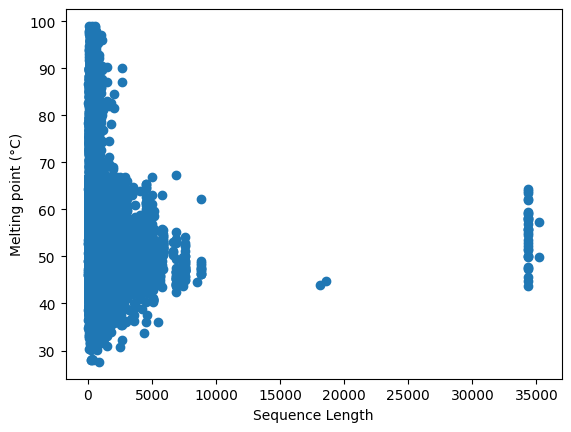

In [2]:
import pylab as pl

pl.scatter(
    [len(entry["sequence"]) for entry in dataset], [entry["temp"] for entry in dataset]
)
pl.xlabel("Sequence Length")
pl.ylabel("Melting point (°C)")

# Display thermo distribution

Max sequence len:  <built-in function max>
Dataset std 6.616701003591255
Thermostability distribution


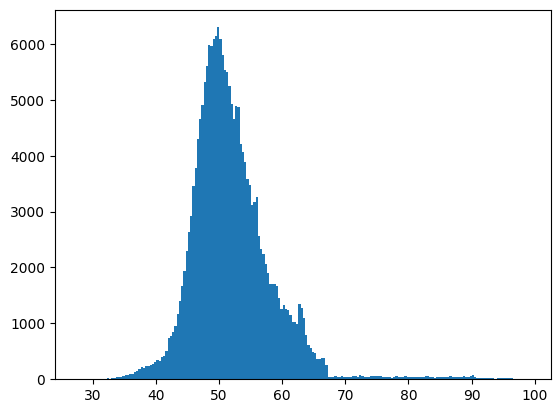

seq len distribution


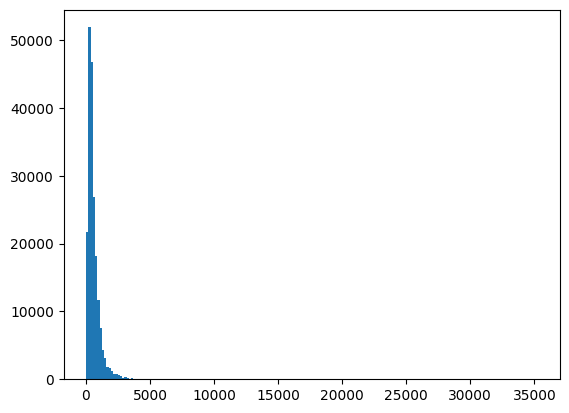

Total entries in ds:  201282
Unique sequences in ds:  34158
Total entries in seqLenConstrainedDs (maxSeqLen: 3000):  199654
Unique sequences in seqLenConstrainedDs (maxSeqLen: 3000):  33989


In [2]:
import numpy as np
import scipy.stats as stats
import pylab as pl

print("Max sequence len: ", max)


def plotDistribution(h: "list[float]"):
    mean = np.mean(h)
    std = np.std(h)
    fit = stats.norm.pdf(h, mean, std)  # this is a fitting indeed
    # pl.plot(h,fit,'-o')
    pl.hist(h, bins=200)  # use this to draw histogram of your data
    pl.show()  # use may also need add this


h = [entry["temp"] for entry in dataset]
print("Dataset std", np.std(h))
print("Thermostability distribution")
plotDistribution(h)

print("seq len distribution")
plotDistribution([len(entry["sequence"]) for entry in dataset])


print("Total entries in ds: ", len(dataset))
uniqueSeqs = set([entry["sequence"] for entry in dataset])
print("Unique sequences in ds: ", len(uniqueSeqs))

maxLen = 3000
seqLenConstrainedDs = [entry for entry in dataset if len(entry["sequence"]) <= maxLen]
print(
    f"Total entries in seqLenConstrainedDs (maxSeqLen: {maxLen}): ",
    len(seqLenConstrainedDs),
)
uniqueSeqs = set([entry["sequence"] for entry in seqLenConstrainedDs])
print(
    f"Unique sequences in seqLenConstrainedDs (maxSeqLen: {maxLen}): ", len(uniqueSeqs)
)

# Distribution of melting point differences of unique sequences in train set

In [3]:
from matplotlib import pyplot
import pandas as pd
import csv
import numpy as np

with open("./data/test.csv", "r") as f:
    spamreader = csv.reader(f, delimiter=",", skipinitialspace=True)
    valSet = [
        (seq, float(thermo))
        for i, (seq, thermo) in enumerate(spamreader)
        if i != 0 and len(seq) < 700
    ]


def getMeasurementsPerProtein(ds: "list[str, float]"):
    seqs = set([seq for (seq, _) in ds])
    tempsPerUniqueSeq = dict([(seq, []) for seq in seqs])
    for seq, temp in ds:
        tempsPerUniqueSeq[seq].append(temp)
    return tempsPerUniqueSeq


def calculatePerProteinMeanStdOfMeasurements(ds: "list[str, float]"):
    tempsPerUniqueSeq = getMeasurementsPerProtein(ds)
    stds = [np.std(d) for d in tempsPerUniqueSeq.values()]
    print("Per-protein mean of stds", np.mean(stds))


def calculateDiffsToPerProteinMeanOfMeasurements(ds: "list[str, float]"):
    tempsPerProtein = getMeasurementsPerProtein(ds)
    diffs = []
    for seq, thermo in ds:
        d = np.mean(tempsPerProtein[seq]) - thermo
        diffs.append(d)

    return diffs


def calculateDiffsToPerProteinMedianOfMeasurements(ds: "list[str, float]"):
    tempsPerProtein = getMeasurementsPerProtein(ds)
    diffs = []
    for seq, thermo in ds:
        d = np.median(tempsPerProtein[seq]) - thermo
        diffs.append(d)

    return diffs


diffsToProteinMean = calculateDiffsToPerProteinMeanOfMeasurements(valSet)
diffsToProteinMedian = calculateDiffsToPerProteinMedianOfMeasurements(valSet)
print("std per protein mean", np.std(diffsToProteinMean))
print("mad to per protein mean", np.mean(np.abs(diffsToProteinMean)))
print("std per protein median", np.std(diffsToProteinMedian))
print("mad to per protein median", np.mean(np.abs(diffsToProteinMedian)))

std per protein mean 2.0090415282803247
mad to per protein mean 1.2618535567913416
std per protein median 2.090872818273358
mad to per protein median 1.2238296765628653


# Distribution of melting point differences of unique sequences

Preparing mean calculation
Calciulating mean
Calculating diffs
Plotting
Mean of stds 0.7523665356352532


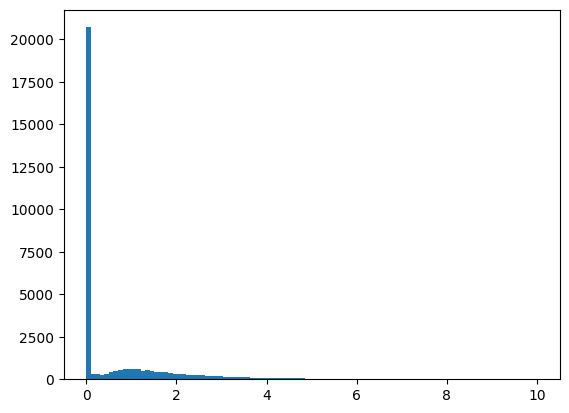

In [4]:
from matplotlib import pyplot
import pandas as pd


means_pre = dict.fromkeys(uniqueSeqs, (0, 0))
print("Preparing mean calculation")
for entry in seqLenConstrainedDs:
    _sum, n = means_pre[entry["sequence"]]
    means_pre[entry["sequence"]] = (_sum + entry["temp"], n + 1)


print("Calciulating mean")
means = {}
for key, (_sum, n) in means_pre.items():
    means[key] = _sum / n

diffs = dict([(seq, []) for seq in uniqueSeqs])

print("Calculating diffs")
for entry in seqLenConstrainedDs:
    d = means[entry["sequence"]] - entry["temp"]
    diffs[entry["sequence"]].append(d)

print("Plotting")


tempsPerUniqueSeq = dict([(seq, []) for seq in uniqueSeqs])
for entry in seqLenConstrainedDs:
    d = entry["temp"]
    tempsPerUniqueSeq[entry["sequence"]].append(d)

stds = [np.std(d) for d in tempsPerUniqueSeq.values()]
print("Mean of stds", np.mean(stds))
pyplot.hist(stds, bins=np.linspace(0, 10, 100))

# for i,seq in enumerate(uniqueSeqs):
#    hist(diffs[seq], str(i))
#    if i==10:
#        break


# pyplot.legend(loc='upper right')
pyplot.show()

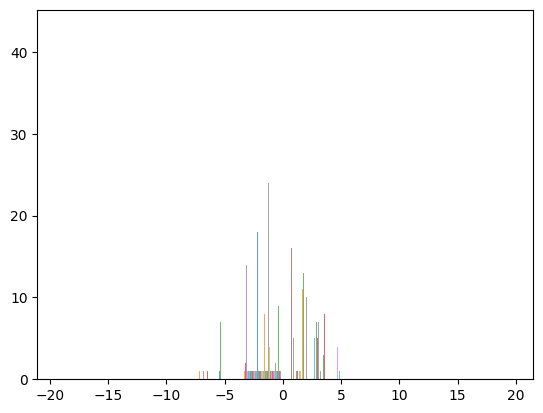

In [ ]:
bins = np.linspace(-10, 10, 100)
pyplot.hist(
    list(diffs.values()), alpha=0.7, label=[str(key) for key in list(diffs.keys())]
)
pyplot.show()

# Count once occuring sequences

In [5]:
nums = dict.fromkeys(uniqueSeqs, 0)
thermos = dict([(seq, []) for seq in uniqueSeqs])
for entry in seqLenConstrainedDs:
    nums[entry["sequence"]] += 1
    thermos[entry["sequence"]].append(entry["temp"])

numOnceOccuring = 0
numMultiple = 0

maxDiff = 2

for count in nums.values():
    if count == 1:
        numOnceOccuring += 1
    elif count > 1:
        numMultiple += 1

numWithinRange = 0
for t in thermos.values():
    if np.max(t) - min(t) <= maxDiff:
        numWithinRange += 1

totalNumMeasurements = sum(nums.values())
avgMeasurementsPerProtein = totalNumMeasurements / len(nums)

print(f"Num unique sequences with max len {maxLen} occuring once:", numOnceOccuring)
print(
    f"Num unique sequences with max len {maxLen} occuring more than once:", numMultiple
)
print(
    f"Num unique sequences with max len {maxLen} having occurances with max temp. diff of {maxDiff}:",
    numWithinRange,
)
print(
    f"Average measurements per protein:",
    avgMeasurementsPerProtein,
)

Num unique sequences with max len 3000 occuring once: 20423
Num unique sequences with max len 3000 occuring more than once: 13566
Num unique sequences with max len 3000 having occurances with max temp. diff of 2: 22994
Average measurements per protein: 5.874076907234693


In [ ]:
import xml.etree.ElementTree as ET

In [ ]:
eval_ids = set()
with open("data/uniref201803_ur50_valid_headers.txt") as txt_file:
    for line in txt_file:
        id = line.split("_")[1].replace("\n", "")
        eval_ids.add(id)
print(iter(eval_ids))

In [ ]:
eval_ds = []
train_ds = []

for entry in dataset:
    if entry["id"] in eval_ids:
        eval_ds.append(entry)
    else:
        train_ds.append(entry)

eval_ds[:3]

[{'id': 'A0A078BPG0',
  'header': '>A0A078BPG0_Caenorhabditis_elegans_lysate MELTING_POINT=41.1098418725276',
  'temp': 41.1098418725276,
  'sequence': 'MSALFQEVKGRQQDFMKAFNAGDAAGAASVYDPDGYFMPNGRNPVKGRSGIEAYFKEDMADGVQTAQIITEEVNGGGDWAFERGSYHLDGTKGRESGAYLQIWKKVEGVWLIHNDCFNVIKNAC'},
 {'id': 'A0A0A6YWP2',
  'header': '>A0A0A6YWP2_Mus_musculus_BMDC_lysate MELTING_POINT=42.1985268328721',
  'temp': 42.1985268328721,
  'sequence': 'MEALKVEKFTTANRGNGLRAVAPLRPGELLFRSDPLAYTVCKGSRGVVCDRCLLGKVVWERAAWLSSEPENI'},
 {'id': 'A0A0K2HAP7',
  'header': '>A0A0K2HAP7_Geobacillus_stearothermophilus_NCA26_lysate MELTING_POINT=72.3790995873377',
  'temp': 72.3790995873377,
  'sequence': 'MHQEIEIELKNLLTAAEFAAVRAAFRLDDGAFFRQENHYFDTPSFALKERAAALRIRAKEGRLTLTLKQTRADGTILEIHEPLSLSEAEAWLAGIAAPRGAIADLLAELGINPHEVRCFGSLVTDRAEWPHEGGTLCLDHNCYLQSEDYELEYEVDHVEAGEKRFLRLLEALGIPRRPAPNKIARFYARMKEMEERR'}]

In [ ]:
def write_to_fasta(filename: str, ds: list):
    with open(f"data/{filename}", "w") as f_fasta:
        for entry in ds:
            f_fasta.write(entry["header"] + " " + entry["sequence"] + "\n")

In [ ]:
write_to_fasta("eval_sequences.fasta", eval_ds)
write_to_fasta("train_sequences.fasta", train_ds)

# Count sequences belonging to same cluster but different set

In [ ]:
maxSeqLen = 700


def extractIdsFromDs(ds):
    return set(
        [
            entry["header"].split()[0][1:]
            for entry in ds
            if len(entry["sequence"]) <= maxSeqLen
        ]
    )


def extractSequenceFromDs(ds):
    return set(
        [entry["sequence"] for entry in ds if len(entry["sequence"]) <= maxSeqLen]
    )


idToSeq = {}
for entry in readFasta("data/full_dataset_sequences.fasta"):
    id = entry["header"].split()[0][1:]
    idToSeq[id] = entry["sequence"]

evalDs = readFasta("data/eval_sequences.fasta")
trainDs = readFasta("data/train_sequences.fasta")

evalIds = extractIdsFromDs(evalDs)
trainIds = extractIdsFromDs(trainDs)

evalSeqs = extractSequenceFromDs(evalDs)
trainSeqs = extractSequenceFromDs(trainDs)

evalClusterIds = set()
trainClusterIds = set()

numClustersWithoutProtein = 0
clusteredProteinIds = set()

clusters = {}
with open("data/meltome_PIDE20_clusters.tsv", "r") as f:
    firstLine = True
    for line in f:
        if firstLine:
            firstLine = False
            continue
        clusterId, proteinId = line.replace("\n", "").split("\t")
        # print("clusterid", clusterId, "proteinId", proteinId)

        if clusterId in clusters:
            clusters[clusterId].add(proteinId)
        else:
            clusters[clusterId] = set([proteinId])

        clusteredProteinIds.add(proteinId)
        if proteinId in evalIds:
            evalClusterIds.add(clusterId)
        elif proteinId in trainIds:
            trainClusterIds.add(clusterId)
        else:
            # print(proteinId)
            numClustersWithoutProtein += 1
print("Unique train seqs before filtering", len(trainSeqs))
numMustBeRemovedFromEval = 0
numMustBeRemovedFromTrain = 0
numOccurences = 0
for clusterId, proteinids in clusters.items():
    numTrain = 0
    numEval = 0
    for proteinId in proteinids:
        if proteinId in trainIds:
            numTrain += 1
        elif proteinId in evalIds:
            numEval += 1

    if numEval > 0 and numTrain > 0:
        numMustBeRemovedFromEval += numEval
        numMustBeRemovedFromTrain += numTrain
        numOccurences += 1
        for proteinId in proteinids:
            if idToSeq[proteinId] in trainSeqs:
                trainSeqs.remove(idToSeq[proteinId])

print("Unique train seqs after filtering", len(trainSeqs))
print("Cluster items", len(clusters.items()))

print("Num trainIds", len(trainIds), "Num evalIds", len(evalIds))
print("Num clusters without protein in our ds: ", numClustersWithoutProtein)
print("Num intersections:", len(evalClusterIds.intersection(trainClusterIds)))
print(
    "Num not intersecting clusters:",
    len(evalClusterIds.difference(trainClusterIds))
    + len(trainClusterIds.difference(evalClusterIds)),
)
print(
    "Num protein ids of our ds not clustered:",
    len(evalClusterIds.union(trainClusterIds).difference(clusteredProteinIds)),
)
print("Num eval protein ids", len(evalIds))
print(
    "Num eval protein ids that must be removed if avoiding cluster data leakage:",
    numMustBeRemovedFromEval,
    "data leakage occuring for ",
    numOccurences,
    "clusters",
)
print(
    "OR Num train protein ids that must be removed if avoiding cluster data leakage:",
    numMustBeRemovedFromTrain,
)
print("Num train protein ids", len(trainIds))

Unique train seqs before filtering 25234
Unique train seqs after filtering 20072
Cluster items 15666
Num trainIds 57630 Num evalIds 4858
Num clusters without protein in our ds:  57187
Num intersections: 991
Num not intersecting clusters: 11497
Num protein ids of our ds not clustered: 0
Num eval protein ids 4858
Num eval protein ids that must be removed if avoiding cluster data leakage: 3873 data leakage occuring for  991 clusters
OR Num train protein ids that must be removed if avoiding cluster data leakage: 12202
Num train protein ids 57630


# Visualize representations

In [24]:
from thermostability.thermo_pregenerated_dataset import (
    ThermostabilityPregeneratedDataset,
    zero_padding_700,
)
from torch.utils.data import DataLoader
import torch
import pylab as pl

ds = ThermostabilityPregeneratedDataset(limit=2, representation_key="s_s")
#dl = DataLoader(
#    ds,
#    batch_size=2,
#    shuffle=True,
#    num_workers=4,
#    collate_fn=zero_padding_700,
#)
#
#inputs, labels = next(iter(dl))
special_color = 'green'

# Create a custom colormap with the special color
cmap = pl.cm.get_cmap('cool')
cmap.set_over(special_color)  # Set special color for values greater than 27
cmap.set_under(special_color)  # Set special color for values less than -27



Omitted 51800 samples of train.csv because
                 their sequences have not been pregenerated


/tmp/ipykernel_708360/4152669786.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = pl.cm.get_cmap('cool')


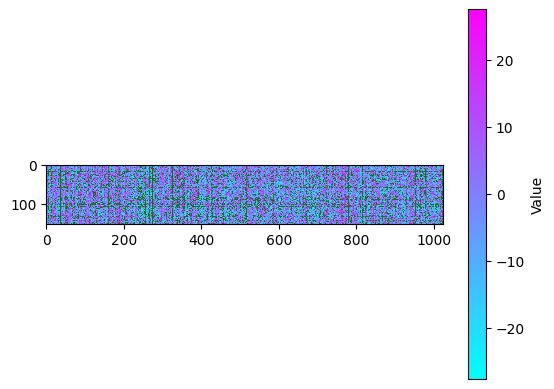

In [25]:
# display ds[0][0] with values greater than 27.55 with white color
#print("juhu",np.ma.masked_greater(ds[0][0], 27.55))

pl.imshow(ds[0][0].squeeze().tolist(), interpolation='nearest', cmap=cmap, vmin=-27.55, vmax=27.55)
cbar = pl.colorbar()
cbar.set_label('Value')

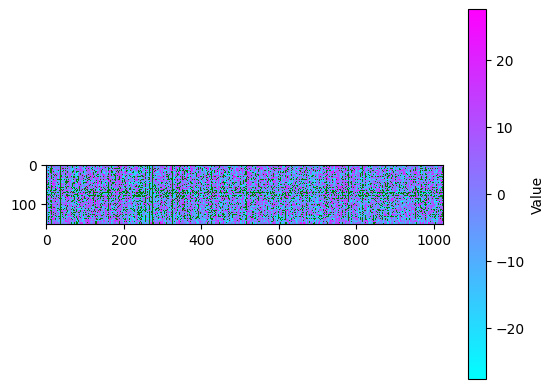

In [26]:
pl.imshow(ds[1][0].squeeze().tolist(), interpolation='nearest', cmap=cmap, vmin=-27.55, vmax=27.55)
cbar = pl.colorbar()
cbar.set_label('Value')

(array([16819.,  1351.,  1441.,  1575.,  1691.,  1808.,  1919.,  1989.,
         2138.,  2287.,  2400.,  2480.,  2602.,  2562.,  2841.,  2899.,
         3033.,  3169.,  3207.,  3369.,  3361.,  3373.,  3476.,  3419.,
         3459.,  3493.,  3381.,  3414.,  3306.,  3298.,  3269.,  3151.,
         3041.,  2965.,  2913.,  2845.,  2638.,  2524.,  2375.,  2219.,
         2229.,  1990.,  1925.,  1836.,  1798.,  1567.,  1468.,  1397.,
         1334., 16604.]),
 array([-27.54999924, -26.44799927, -25.3459993 , -24.24399933,
        -23.14199936, -22.03999939, -20.93799942, -19.83599945,
        -18.73399948, -17.63199951, -16.52999954, -15.42799957,
        -14.3259996 , -13.22399963, -12.12199966, -11.01999969,
         -9.91799973,  -8.81599976,  -7.71399979,  -6.61199982,
         -5.50999985,  -4.40799988,  -3.30599991,  -2.20399994,
         -1.10199997,   0.        ,   1.10199997,   2.20399994,
          3.30599991,   4.40799988,   5.50999985,   6.61199982,
          7.71399979,   8.8159

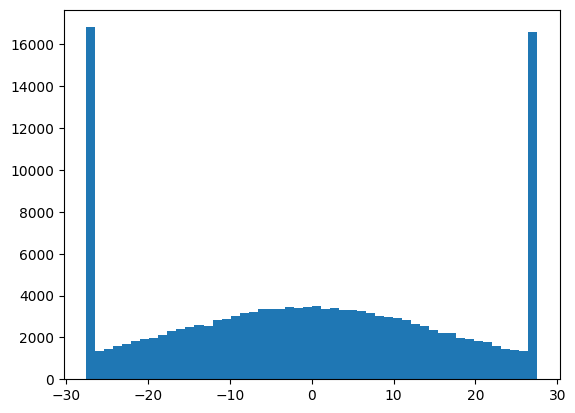

In [23]:
pl.hist(ds[1][0].flatten().squeeze().clamp(min=-27.55, max=27.55).tolist(), bins=50)

In [20]:
np.percentile(ds[1][0].flatten().squeeze().tolist(),10)

-27.555008697509763